In [0]:
# Check GPU for Google Colab
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=ad847b1eb89535d837ad01429d61d3d8e75c27997d6d596071e0783167a93883
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


IndexError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## This version uses shared weights layers.
## It uses created triplet loss

In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout, Add, merge, Subtract
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import concatenate, Lambda, Activation
from keras import backend as K
from keras.utils import np_utils
import h5py
import time
import keras.layers
from keras.engine.topology import Layer
from sklearn.decomposition import PCA

from scipy.spatial import distance
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [0]:
category = "building"

# number of points in each sample
num_points = 2048

## **This version uses different poitnet**
It works, but does not learn.
Using different triplet loss.
https://github.com/TianzhongSong/PointNet-Keras/blob/master/model_cls.py

In [0]:
def mat_mul(A, B):
    return tf.matmul(A, B)


def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    id = f['id'][:]
    return (data, label, id)


def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data
  




class MatMul(Layer):

    def __init__(self, **kwargs):
        super(MatMul, self).__init__(**kwargs)

    def build(self, input_shape):
        # Used purely for shape validation.
        if not isinstance(input_shape, list):
            raise ValueError('`MatMul` layer should be called '
                             'on a list of inputs')
        if len(input_shape) != 2:
            raise ValueError('The input of `MatMul` layer should be a list containing 2 elements')

        if len(input_shape[0]) != 3 or len(input_shape[1]) != 3:
            raise ValueError('The dimensions of each element of inputs should be 3')

        if input_shape[0][-1] != input_shape[1][1]:
            raise ValueError('The last dimension of inputs[0] should match the dimension 1 of inputs[1]')

    def call(self, inputs):
        if not isinstance(inputs, list):
            raise ValueError('A `MatMul` layer should be called '
                             'on a list of inputs.')
        return tf.matmul(inputs[0], inputs[1])

    def compute_output_shape(self, input_shape):
        output_shape = [input_shape[0][0], input_shape[0][1], input_shape[1][-1]]
        return tuple(output_shape)


def create_base_model():
    input_points = Input(shape=(num_points, 3))
    # issues
    # input transformation net
    x = Convolution1D(64, 1, activation='relu')(input_points)
    x = BatchNormalization()(x)
    x = Convolution1D(128, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Convolution1D(1024, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=num_points)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
    input_T = Reshape((3, 3))(x)

    # forward net
    g = MatMul()([input_points, input_T])
    g = Convolution1D(64, 1, activation='relu')(g)
    g = BatchNormalization()(g)
    g = Convolution1D(64, 1, activation='relu')(g)
    g = BatchNormalization()(g)

    # feature transform net
    f = Convolution1D(64, 1, activation='relu')(g)
    f = BatchNormalization()(f)
    f = Convolution1D(128, 1, activation='relu')(f)
    f = BatchNormalization()(f)
    f = Convolution1D(1024, 1, activation='relu')(f)
    f = BatchNormalization()(f)
    f = MaxPooling1D(pool_size=num_points)(f)
    f = Dense(512, activation='relu')(f)
    f = BatchNormalization()(f)
    f = Dense(256, activation='relu')(f)
    f = BatchNormalization()(f)
    f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
    feature_T = Reshape((64, 64))(f)

    # forward net
    g = MatMul()([g, feature_T])
    g = Convolution1D(64, 1, activation='relu')(g)
    g = BatchNormalization()(g)
    g = Convolution1D(128, 1, activation='relu')(g)
    g = BatchNormalization()(g)
    g = Convolution1D(1024, 1, activation='relu')(g)
    g = BatchNormalization()(g)

    # global feature
    global_feature = MaxPooling1D(pool_size=num_points)(g)
#     global_feature = Activation('sigmoid')(global_feature)
    out = Flatten(name='out')(global_feature)
    
    model = Model(inputs=input_points, outputs=out)
#     print(model.summary())

    return model


In [0]:
# ## Using pretrained model

# def create_base_model():
#   input_points = Input(shape=(num_points, 3))
#   # input transformation net
#   x = Convolution1D(64, 1, activation='relu')(input_points)
#   x = BatchNormalization()(x)
#   x = Convolution1D(128, 1, activation='relu')(x)
#   x = BatchNormalization()(x)
#   x = Convolution1D(1024, 1, activation='relu')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling1D(pool_size=num_points)(x)

#   x = Dense(512, activation='relu')(x)
#   x = BatchNormalization()(x)
#   x = Dense(256, activation='relu')(x)
#   x = BatchNormalization()(x)

#   x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
#   input_T = Reshape((3, 3))(x)

#   # forward net
#   g = MatMul()([input_points, input_T])
#   g = Convolution1D(64, 1, activation='relu')(g)
#   g = BatchNormalization()(g)
#   g = Convolution1D(64, 1, activation='relu')(g)
#   g = BatchNormalization()(g)

#   # feature transform net
#   f = Convolution1D(64, 1, activation='relu')(g)
#   f = BatchNormalization()(f)
#   f = Convolution1D(128, 1, activation='relu')(f)
#   f = BatchNormalization()(f)
#   f = Convolution1D(1024, 1, activation='relu')(f)
#   f = BatchNormalization()(f)
#   f = MaxPooling1D(pool_size=num_points)(f)
#   f = Dense(512, activation='relu')(f)
#   f = BatchNormalization()(f)
#   f = Dense(256, activation='relu')(f)
#   f = BatchNormalization()(f)
#   f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
#   feature_T = Reshape((64, 64))(f)

#   # forward net
#   g = MatMul()([g, feature_T])
#   g = Convolution1D(64, 1, activation='relu')(g)
#   g = BatchNormalization()(g)
#   g = Convolution1D(128, 1, activation='relu')(g)
#   g = BatchNormalization()(g)
#   g = Convolution1D(1024, 1, activation='relu')(g)
#   g = BatchNormalization()(g)

#   # global feature
#   global_feature = MaxPooling1D(pool_size=num_points)(g)
#   #     global_feature = Activation('sigmoid')(global_feature)
#   # out = Flatten()(global_feature)

#   # point_net_cls
#   c = Dense(512, activation='relu')(global_feature)
#   c = BatchNormalization()(c)
#   c = Dropout(0.5)(c)
#   c = Dense(256, activation='relu')(c)
#   c = BatchNormalization()(c)
#   c = Dropout(0.5)(c)
#   c = Dense(3, activation='softmax')(c)
#   prediction = Flatten()(c)

#   pre_model = Model(inputs=input_points, outputs=prediction)
#   pre_model.load_weights('drive/My Drive/Weights/model_pretrain.h5')
  
#   ## Visualize network
#   from keras.utils.vis_utils import plot_model as plot
#   plot(pre_model, to_file = 'drive/My Drive/Triplet_Network_o.png')
    
#   out =  Flatten()(pre_model.get_layer("max_pooling1d_3").output)
#   model = Model(inputs=pre_model.input, outputs=out)

#   return model

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2, beta = 0.1):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    
#     total_length = y_pred.shape.as_list()[-1]
    total_length = 1024*3
    
    anchor = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

     # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss_a = pos_dist-neg_dist+alpha
    loss_a = K.maximum(basic_loss_a,0.0)
    
    basic_loss_b = pos_dist - beta
    loss_b = K.maximum(basic_loss_b,0.0)
    
    loss = loss_a + loss_b
    
    return loss_a

In [0]:
def compile_model(): 
  print("Compiling model...")
  input_anchor = Input(shape=(num_points, 3))
  input_positive = Input(shape=(num_points, 3))
  input_negative = Input(shape=(num_points, 3))

  model_shared = create_base_model()

  encoded_anchor = model_shared(input_anchor)
  encoded_positive = model_shared(input_positive)
  encoded_negative = model_shared(input_negative)

#   optim = optimizers.Adam(lr=0.000001)
  optim = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=0.000001, decay=0.0)
  # optim = optimizers.RMSprop(lr=0.00001)

  merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=1, name='merged_layer')

  model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_vector)
  model.compile(loss=triplet_loss, optimizer=optim)

  ## Visualize network
#   from keras.utils.vis_utils import plot_model as plot
#   plot(model, to_file = 'drive/My Drive/Triplet_Network_o.png')


#   model.summary()

  return model
  

# Display point cloud

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_pc(points):
  # select one test data to visualize
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  v_points = points
  v_points = np.squeeze(v_points)

  for i in range(v_points.shape[0]):
      xs = v_points[i,0]
      ys = v_points[i,1]
      zs = v_points[i,2]
      ax.scatter(xs, ys, zs, color="blue", s=5)

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()

## Train on Style Data 1

In [0]:
def evaluate_triplet(mode="train"):
  # Evaluate on test data
  if mode == "train":
    X_test = [Anchor_train, Positive_train, Negative_train]
    Y_dummy = np.zeros((Anchor_train.shape[0],1))
  elif mode == "test":
    X_test = [Anchor_test, Positive_test, Negative_test]
    Y_dummy = np.zeros((Anchor_test.shape[0],1))
  
  pred = model.predict(x=X_test, verbose=1)
  
  # Split into anchor, a, and b sets
  total_lenght = pred.shape[1]
  pred_anchor = pred[:,0:int(total_lenght*1/3)]
  pred_a = pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  pred_b = pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  pred_a.shape
  
#   print(pred_anchor)

  result = []
  for i in range(pred.shape[0]):
    dist1 = distance.euclidean(pred_anchor[i], pred_a[i])
    dist2 = distance.euclidean(pred_anchor[i], pred_b[i])
#     print(pred_anchor[0])
#     print(pred_a[0])
#     print(pred_b[0])
#     print("Positive dist: ", dist1)
#     print("Negative dist: ", dist2)
    if dist1 < dist2:
      result.append(0)
    else:
      result.append(1)   

  print("Evaluation accuracy: ", accuracy_score(Y_dummy, result))

  return accuracy_score(Y_dummy, result)


In [0]:
def plot_3d(img_id=1):
  total_length = 1500
  
  print("Plotting...")
  # Evaluate on test data
  X = [input_data_anchor_test,input_data_a_test, input_data_b_test]
  y_pred = model.predict(x=X,verbose=1)
  
  anchor = y_pred[:,0:int(total_length*1/3)]
  positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
  negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

  data_plot = np.concatenate([anchor,positive,negative])

  
  pca = PCA(n_components=3)
  pca.fit(data_plot)

  data_plot = pca.transform(data_plot)

  # Set colors
  colors = []
  num_data = 1
  for i in range(0,num_data):
    colors.append("red")
  for i in range(0,num_data):
    colors.append("blue")
  for i in range(0,num_data):
    colors.append("green")

  fig = plt.figure()
  ax = Axes3D(fig)

  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")

  ax.scatter(data_plot[:,0], data_plot[:,1], data_plot[:,2], marker="o", color=colors, linestyle='None')
  
  img_name = "drive/My Drive/Saved_Images/figure" + str(img_id) + ".png"
  plt.savefig(img_name) 

  plt.show()

In [0]:
def save_plot(eval_name, fold_id):
  fig = plt.figure()

  # top
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.plot(df_history[0])
  ax1.plot(df_history[1])
  ax1.set_xlabel("epoch")
  ax1.set_ylabel("loss")
  plt.legend(['train_loss', 'val_loss'], loc='upper right', fontsize='x-small')
  plt.title("Fold-"+str(fold_id))

  # bottom
  ax2 = fig.add_subplot(2, 1, 2)
  ax2.plot(df_history[2])
  ax2.set_xlabel("epoch")
  ax2.set_ylabel("accuracy")
  plt.legend(['val_accuracy'], loc='upper left', fontsize='x-small')

#   fig.show()
  fig.savefig("drive/My Drive/Saved_Images/CV_eval_pc/" + eval_name + "/Fold-"+str(fold_id))
  plt.close()

In [0]:
## Create two plots; accuracy and loss
def save_plot(eval_name, fold_id):
  fig = plt.figure()

  # top
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.plot(df_history['train_loss'], color='blue')
  ax1.plot(df_history['val_loss'], color='darkorange')
  ax1.set_xlabel("epoch")
  ax1.set_ylabel("loss")
  plt.legend(['train_loss', 'val_loss'], loc='upper right', fontsize='x-small')
  plt.title("Fold-"+str(fold_id))

  # bottom
  ax2 = fig.add_subplot(2, 1, 2)
  ax2.plot(df_history['val_acc'], color='orange')
  ax2.set_xlabel("epoch")
  ax2.set_ylabel("accuracy")
  plt.legend(['val_accuracy'], loc='upper left', fontsize='x-small')

#   fig.show()
  fig.savefig("drive/My Drive/Saved_Images/CV_eval_pc/" + eval_name + "/Fold-"+str(fold_id))
  plt.close()

In [47]:
# Load point cloud
num_points = 2048
# Load point cloud data
train_path = "drive/My Drive/style_data_2/"

filenames = [d for d in os.listdir(train_path)]
print(train_path)
print(filenames)
train_points = None
train_labels = None
train_ids = None
for d in filenames:
    cur_points, cur_labels, cur_ids = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    cur_ids = cur_ids.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
        train_ids = cur_ids
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
        train_ids = np.hstack((train_ids, cur_ids))
train_points_r = train_points.reshape(-1, num_points, 3)
train_labels_r = train_labels.reshape(-1, 1)
train_ids_r = train_ids.reshape(-1, 1)



def data_generator(fold_id):  
  ## Generate training/test data
  df_train = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_train_" + str(fold_id) + ".csv")
  df_test = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_test_" + str(fold_id) + ".csv")

  df_train = df_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  out_list = []
  ################ Generate Training Data ################
  name_list = ["query", "pos", "neg"]
  data_length = len(df_train)

  for k in range(0,3):
    print("Generating training data", k+1, "/3...")
    input_data = pd.DataFrame()
    df_ids = pd.DataFrame(train_ids_r)
    for i in range(data_length):
        data_id = df_train.loc[:,name_list[k]][i]
        id_index = df_ids[df_ids[0].astype(str)== ("b'"+data_id + ".off'")].index
        input_data = input_data.append(pd.DataFrame(train_points_r[id_index[0]][:,[0,2,1]]))
        
    input_data = input_data.as_matrix()
    input_data = input_data.reshape(-1, num_points, 3)
    out_list.append(np.array(input_data))


  ############### Generate Test Data #########################
  data_length = len(df_test)

  for k in range(0,3):
    print("Generating training data", k+1, "/3...")
    input_data = pd.DataFrame()
    df_ids = pd.DataFrame(train_ids_r)
    for i in range(data_length):
        data_id = df_test.loc[:,name_list[k]][i]
        id_index = df_ids[df_ids[0].astype(str)== ("b'"+data_id + ".off'")].index
        input_data = input_data.append(pd.DataFrame(train_points_r[id_index[0]][:,[0,2,1]]))

    input_data = input_data.as_matrix()
    input_data = input_data.reshape(-1, num_points, 3)
    out_list.append(np.array(input_data))
    
  return out_list



drive/My Drive/style_data_2/
['train_style_model_2.h5']


In [52]:
##### 10-fold cross-validation ###########
for k in range(1,11):
  
  print("==================== Fold:", k, "/10 ========================")
  ####### Use for style data 1 #######
  # Training and testing data
  generated_data = data_generator(1)
  model = compile_model()

  Anchor_train = generated_data[0]
  Positive_train = generated_data[1]
  Negative_train = generated_data[2]

  Anchor_test = generated_data[3]
  Positive_test = generated_data[4]
  Negative_test = generated_data[5]

  Y_dummy1 = np.zeros((Anchor_train.shape[0],1))
  Y_dummy2 = np.zeros((Anchor_test.shape[0],1))


  # Time
  start = time.time()

  num_epoch = 500
  # Fit model on training data
  df_history = pd.DataFrame(columns=['train_loss','val_loss','train_acc','val_acc'])
  for i in range(1, num_epoch):
    print("\n Total epoch:", i, "/", num_epoch)

    # rotate and jitter the points
    train_points_rotate = rotate_point_cloud(Anchor_train)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    Anchor_train = jitter_point_cloud(Anchor_train)
    train_points_rotate = rotate_point_cloud(Positive_train)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    Positive_train = jitter_point_cloud(Positive_train)
    train_points_rotate = rotate_point_cloud(Negative_train)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    Negative_train = jitter_point_cloud(Negative_train) # !!!!!!!!!! changed !!!!!!!!!!!


    # Evaluation
    val_acc = evaluate_triplet("test")
    train_acc = evaluate_triplet("train")

    history = model.fit(x=[Anchor_train, Positive_train, Negative_train], y=Y_dummy1,\
                           validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),\
                           batch_size=16, shuffle=True, epochs=1,verbose=1)


    df_history = df_history.append(pd.DataFrame([history.history['loss'], history.history['val_loss'], [train_acc], [val_acc]],
                                               index=['train_loss','val_loss','train_acc','val_acc']).T)
    df_history = df_history.reset_index(drop="Ture")


    # Elapsed time
    elapsed_time = time.time() - start
    print("Elapsed time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

    if i%10==0 and i>1:
      # Create and save plot
      save_plot(category, fold_id=k)
      # Save a list of accuracy
      df_history.to_csv("drive/My Drive/PointCloudAccuracy_10CV/Lun_" + category + "/df_log_"+ str(k) + ".csv")
  
 
  #   model.save_weights("drive/My Drive/Weights/style_model_weights.h5")
  #     plot_3d(i)


==================== Fold: 1 /10 ========================
Generating training data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Generating training data 1 /3...
Generating training data 2 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 3 /3...
Compiling model...

 Total epoch: 1 / 500
80/80 [==============================] - 10s 127ms/step
Evaluation accuracy:  0.6
627/627 [==============================] - 15s 24ms/step
Evaluation accuracy:  0.5677830940988836
Train on 627 samples, validate on 80 samples
Epoch 1/1
627/627 [==============================] - 63s 101ms/step - loss: 269.4898 - val_loss: 348.8543
Elapsed time: 00:01:35

 Total epoch: 2 / 500
80/80 [==============================] - 2s 23ms/step
Evaluation accuracy:  0.55
627/627 [==============================] - 15s 24ms/step
Evaluation accuracy:  0.5422647527910686
Train on 627 samples, validate on 80 samples
Epoch 1/1
627/627 [==============================] - 47s 75ms/step - loss: 48.5668 - val_loss: 101.2299
Elapsed time: 00:02:40

 Total epoch: 3 / 500
80/80 [==============================] - 2s 23ms/step
Evaluation accuracy:  0.5625
627/627 [==============================] - 15s 24ms/step
Evaluation accuracy:  0.5470494417

KeyboardInterrupt: ignored

In [0]:
df_train = pd.read_pickle("drive/My Drive/10CV_df/Lun_building/df_train_1.csv").reset_index(drop=True)

In [36]:
df_train.loc[:,"query"][0]

'148'

In [54]:
df_train

,query,pos,neg
0,148,157,161
1,100,95,207
2,159,58,167
3,55,187,44
4,97,44,189
...,...,...,...
622,194,111,89
623,58,26,105
624,238,216,32
625,187,99,34


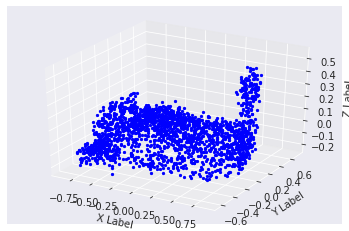

In [53]:
id = 0
show_pc(Anchor_train[id,:,:])

# train_points_rotate = rotate_point_cloud(Anchor_train[id,:,:])
# train_points_jitter = jitter_point_cloud(train_points_rotate)
# show_pc(train_points_rotate)
# show_pc(train_points_jitter)

# show_pc(input_data_a_trai)
# show_pc(input_data_b_train[id,:,:])

In [0]:
df_history[0]

TypeError: ignored

In [0]:
evaluate_triplet("train")

702/702 [==============================] - 20s 28ms/step
Evaluation accuracy:  0.5555555555555556


In [0]:
from scipy.spatial import distance

# Evaluate on test data
X_train = [input_data_anchor_train,input_data_a_train, input_data_b_train]
y_pred = model.predict(x=X_train,verbose=1)

total_length = 1500
alpha=50
    
anchor = y_pred[:,0:int(total_length*1/3)]
positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

pos_dist = distance.euclidean(anchor[0], positive[0])
neg_dist = distance.euclidean(anchor[0], negative[0])

# compute loss
basic_loss = pos_dist - neg_dist + alpha
loss = max(basic_loss,0.0)

print("pos_dist: ", pos_dist)
print("neg_dist: ", neg_dist)
print("Loss:", loss)


201/201 [==============================] - 5s 24ms/step
pos_dist:  37.07339096069336
neg_dist:  35.5369758605957
Loss: 51.536415100097656


In [0]:
# Evaluate on test data
y_true = np.zeros((X_test[0].shape[0],1))
pred = model.predict(x=X_test,verbose=1)

NameError: ignored

In [0]:
# Evaluate on training data
y_true = np.zeros((X_train[0].shape[0],1))
pred = model.predict(x=X_train,verbose=1)

201/201 [==============================] - 5s 24ms/step


In [0]:
# Evaluate
total_lenght = pred.shape[1]
pred_anchor = pred[:,0:int(total_lenght*1/3)]
pred_a = pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
pred_b = pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
pred_a.shape

y_pred = []
for i in range(pred.shape[0]):
  dist_pos = distance.euclidean(pred_anchor[i], pred_a[i])
  dist_neg = distance.euclidean(pred_anchor[i], pred_b[i])
  print("Triplet", i, ":")
  print("dist_pos", dist_pos)
  print("dist_neg", dist_neg)
  print("---------------------------------")
  if dist_pos < dist_neg:
    y_pred.append(0)
  else:
    y_pred.append(1)   
    

print(accuracy_score(y_true, y_pred))

Triplet 0 :
dist_pos 4.61159086227417
dist_neg 4.509746551513672
---------------------------------
Triplet 1 :
dist_pos 11.08251953125
dist_neg 12.058765411376953
---------------------------------
Triplet 2 :
dist_pos 11.08251953125
dist_neg 11.017613410949707
---------------------------------
Triplet 3 :
dist_pos 4.61159086227417
dist_neg 4.725347518920898
---------------------------------
Triplet 4 :
dist_pos 10.023204803466797
dist_neg 10.463550567626953
---------------------------------
Triplet 5 :
dist_pos 9.939489364624023
dist_neg 12.058765411376953
---------------------------------
Triplet 6 :
dist_pos 10.023204803466797
dist_neg 9.752119064331055
---------------------------------
Triplet 7 :
dist_pos 5.878297328948975
dist_neg 6.098970413208008
---------------------------------
Triplet 8 :
dist_pos 10.085077285766602
dist_neg 4.949539661407471
---------------------------------
Triplet 9 :
dist_pos 10.615157127380371
dist_neg 8.90152359008789
---------------------------------
T

In [0]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)


In [0]:
# Scaling
from sklearn import preprocessing
mm = preprocessing.MinMaxScaler()
for i in range(len(test_points)):
    test_points[i] = mm.fit_transform(test_points[i])